In [1]:
import warnings

warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import BaseCrossValidator
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor, \
    GradientBoostingRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

from scipy.stats import spearmanr

In [3]:
dataset_path = '../data/model_data.h5'

# Load Data

In [4]:
data = pd.read_hdf(dataset_path, 'no_dummies')

In [5]:
data = data.drop([c for c in data.columns if 'lag' in c], axis=1)
data

,Close,Volume,Open,High,Low,Consumption in mcf,Storage in mcf,US Gross Withdrawal in mcf,Other Gross Withdrawal in mcf,RSI,...,return_21d,return_42d,return_63d,target_1d,target_5d,target_10d,target_21d,year,month,weekday
Date,,,,,,,,,,,,,,,,,,,,,
2012-04-09,2.107,108772.0,2.103,2.117,2.065,1953071.0,2478.0,2417498.0,93400.0,34.901425,...,-0.003584,-0.003797,-0.005916,-0.036070,-0.015267,-0.006449,0.007501,2012,4,0
2012-04-10,2.031,120126.0,2.111,2.125,2.025,1953071.0,2478.0,2417498.0,93400.0,30.556017,...,-0.006397,-0.004436,-0.006230,-0.023634,-0.008005,0.001807,0.009692,2012,4,1
2012-04-12,1.983,188668.0,1.976,2.068,1.972,1953071.0,2478.0,2417498.0,93400.0,28.170441,...,-0.006395,-0.005282,-0.006237,-0.001009,-0.007785,0.002641,0.011266,2012,4,3
2012-04-13,1.981,111947.0,1.982,1.999,1.959,1953071.0,2503.0,2417498.0,93400.0,28.072097,...,-0.007064,-0.005306,-0.005330,0.017668,-0.005512,0.009896,0.009795,2012,4,4
2012-04-16,2.016,115321.0,1.986,2.030,1.977,1953071.0,2503.0,2417498.0,93400.0,32.512260,...,-0.005926,-0.004447,-0.004609,-0.032242,-0.000894,0.012604,0.010299,2012,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,4.102,47082.0,4.025,4.187,4.010,2218011.0,2714.0,3396062.0,32500.0,79.676063,...,0.008724,0.008183,0.006137,-0.031936,-0.008278,-0.001029,-0.002451,2021,7,0
2021-07-27,3.971,40472.0,4.095,4.114,3.934,2218011.0,2714.0,3396062.0,32500.0,67.674236,...,0.006085,0.006827,0.005151,0.018383,0.002805,0.002933,-0.000895,2021,7,1
2021-07-28,4.044,3877.0,3.947,4.064,3.874,2218011.0,2714.0,3396062.0,32500.0,70.354143,...,0.005647,0.007474,0.005155,0.003709,0.005575,0.000370,0.001622,2021,7,2


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2330 entries, 2012-04-09 to 2021-07-30
Data columns (total 25 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Close                          2330 non-null   float64
 1   Volume                         2330 non-null   float64
 2   Open                           2330 non-null   float64
 3   High                           2330 non-null   float64
 4   Low                            2330 non-null   float64
 5   Consumption in mcf             2330 non-null   float64
 6   Storage in mcf                 2330 non-null   float64
 7   US Gross Withdrawal in mcf     2330 non-null   float64
 8   Other Gross Withdrawal in mcf  2330 non-null   float64
 9   RSI                            2330 non-null   float64
 10  ATR                            2330 non-null   float64
 11  MACD                           2330 non-null   float64
 12  return_1d                     

In [7]:
columns_to_drop = ['Open', 'Close', 'Low', 'High', 'Volume']
y = data.filter(like='target')
X = data.drop(columns_to_drop, axis=1)
X = X.drop(y.columns, axis=1)

In [8]:

class MultipleTimeSeriesCV(BaseCrossValidator):
    """Generates tuples of train_idx, test_idx pairs"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values('Date').unique()
        days = sorted(unique_dates, reverse=True)

        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[['Date']]
        for train_start, train_end, test_start, test_end in split_idx:
            train_idx = dates[(dates.Date > days[train_start])
                              & (dates.Date <= days[train_end])].index
            test_idx = dates[(dates.Date > days[test_start])
                             & (dates.Date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx, test_idx

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

In [9]:
n_splits = 20
train_period_length = 300
test_period_length = 100
lookahead = 5

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          train_period_length=train_period_length,
                          test_period_length=test_period_length,
                          lookahead=lookahead)

In [10]:
# Utilities functions

def display_score(scores):
    print('scores: ',scores)
    print('mean: ', scores.mean())
    print('standard deviation: ', scores.std())


def rank_correl(y, y_pred):
    return spearmanr(y, y_pred, axis=None)[0]

ic = make_scorer(rank_correl)


def get_cross_val_score(model, X, y, score_fun, cv, n_jobs=-1):
    cv_score = cross_val_score(estimator=model,
                           X=X,
                           y=y,
                           scoring=score_fun,
                           cv=cv,
                           n_jobs=n_jobs,
                           verbose=1)
    display_score(cv_score)

# Decision Tree Regressor

In [11]:
dt_reg = DecisionTreeRegressor(max_depth=None,
                               min_samples_split=2,
                               min_samples_leaf=1,
                               max_features='auto')


In [12]:
get_cross_val_score(dt_reg, X, y, ic, cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [ 0.04464092  0.08207146  0.22487404 -0.13411264 -0.18428023  0.13710645
  0.16271606 -0.1108652   0.0796875   0.08466114  0.15419403  0.08893478
 -0.03116279  0.09769417  0.05050973 -0.07860061  0.08467794  0.01772508
 -0.07314027  0.16875813]
mean:  0.04330448359598375
standard deviation:  0.10887221764227978


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    2.2s finished


# Random Forest Regressor

In [13]:
rf_reg = RandomForestRegressor(n_estimators=100,
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                min_weight_fraction_leaf=0.0,
                                max_features='auto',
                                max_leaf_nodes=None,
                                min_impurity_decrease=0.0,
                                bootstrap=True,
                                oob_score=False,
                                n_jobs=-1,
                                random_state=None,
                                verbose=0,
                                warm_start=False)

In [14]:
get_cross_val_score(rf_reg, X, y, ic, cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [ 0.15759642  0.14805955  0.17503872  0.06307502 -0.15633791  0.30566667
  0.30461727 -0.04459528  0.14375584  0.08820655  0.15681158  0.17516284
  0.01181858  0.17490326  0.00947312  0.17740333  0.08379446  0.10136463
  0.07392384  0.02245327]
mean:  0.1086095874577975
standard deviation:  0.1066265032885134


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    3.7s finished


# Ada Boosting Regressor

In [15]:
ada_reg = AdaBoostRegressor(n_estimators=100,
                            loss='square')

In [16]:
get_cross_val_score(ada_reg, X, y['target_5d'], ic, cv)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 3 concurrent workers.


scores:  [ 0.36351742  0.22185013  0.29566878 -0.18664972 -0.309626    0.12209503
  0.38736703  0.0608958  -0.03743221  0.1303804   0.08309294  0.2157596
  0.12175065  0.17395639 -0.0332344   0.12311378 -0.15686645  0.11007594
 -0.06401134 -0.05608593]
mean:  0.07828089287987677
standard deviation:  0.17646088287814557


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    1.9s finished


# Gradient Boosting Regressor

In [17]:
grad_reg = GradientBoostingRegressor(n_estimators=250,
                                        max_depth=None,
                                        min_samples_split=2,
                                        min_samples_leaf=1,
                                        min_weight_fraction_leaf=0.0,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        random_state=None,
                                        verbose=0,
                                        warm_start=False)

In [18]:
get_cross_val_score(grad_reg, X, y['target_5d'], ic, cv, n_jobs=1)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


scores:  [ 0.41269251  0.11524752  0.20078008  0.20714134 -0.336685    0.16512451
 -0.03878316 -0.18121812 -0.03811581  0.09037585 -0.07136535  0.31613056
  0.14108561  0.12139214 -0.06120704 -0.06012601  0.10606661  0.12498125
 -0.01429343 -0.17035704]
mean:  0.05144335073907354
standard deviation:  0.17343687520094284


[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:   10.4s finished


It seems like that the best learner is the `RandomTreesRegressor`. Let's fine tune it in order to find
the bests parameters

## Hyperparamter Options

In [19]:
n_estimators = [100, 250]
max_depth = [5, 15, None]
min_samples_leaf = [5, 25, 100]

In [20]:
from itertools import product

cv_params = list(product(n_estimators,
                         max_depth,
                         min_samples_leaf))
n_cv_params = len(cv_params)
n_cv_params

18

In [21]:
sample_proportion = .6
sample_size = int(sample_proportion * n_cv_params)

cv_param_sample = np.random.choice(list(range(n_cv_params)),
                                     size=int(sample_size),
                                     replace=False)
cv_params_ = [cv_params[i] for i in cv_param_sample]
print('# CV parameters:', len(cv_params_))

# CV parameters: 10


## Train/Test Period Lenghts

In [22]:
YEAR = 252
train_lengths = [5 * YEAR, 3 * YEAR, YEAR, 126, 63]
test_lengths = [5, 21]

In [23]:
test_params = list(product(train_lengths, test_lengths))
n_test_params = len(test_params)
print('# period params: ', n_test_params)

# period params:  10


## Run cross-validation

In [24]:
labels = sorted(y.columns)
features = X.columns.tolist()
lookaheads = [1, 5, 10, 21]

In [25]:
label_dict = dict(zip(lookaheads, labels))

In [26]:
cross_val_cols = [
    'train_length',
    'test_length',
    'n_estimators',
    'max_depth',
    'min_samples_leaf',
    'mean_ic',
    'std_ic',
    'rounds',
    'target'
]

cross_val_results = pd.DataFrame(columns=cross_val_cols)

In [27]:
run_cross_val = False

if run_cross_val:
    for lookahead in lookaheads:
        for train_length, test_length in test_params:
            n_splits = int(4 * YEAR / test_length)
            res_row = dict(zip(cross_val_results, [None] * len(cross_val_results)))

            cv = MultipleTimeSeriesCV(n_splits=n_splits,
                                      test_period_length=test_length,
                                      train_period_length=train_length,
                                      lookahead=lookahead)

            res_row['target'] = lookahead
            res_row['train_length'] = train_length
            res_row['test_length'] = test_length


            for p, (n_estimator, max_d, min_s_l) in enumerate(cv_params_):
                base_params = rf_reg.get_params()
                model = RandomForestRegressor(base_params)
                model_params = {
                    'n_estimators': n_estimator,
                    'max_depth': max_d,
                    'max_features': 'log2',
                    'min_samples_leaf': min_s_l
                }
                model = model.set_params(**model_params)

                cval_score = cross_val_score(
                    estimator=model,
                    X=X,
                    y=y,
                    cv=cv,
                    n_jobs=-1,
                    scoring=ic
                )

                for k, v in model_params.items():
                    res_row[k] = v

                res_row['mean_ic'] = cval_score.mean()
                res_row['std_ic'] = cval_score.std()
                res_row['rounds'] = len(cval_score)
                cross_val_results = cross_val_results.append(res_row, ignore_index=True)
                print(f'Lookback: {lookahead}, Train size: {train_length}, Test size: {test_length} ' + \
                      f'# estimators: {n_estimator}, max depth: {max_d}, min samples leaf: {min_s_l}, ic: {cval_score.mean()}')

In [28]:
save = False

if save:
    cross_val_results.to_hdf('./rf_cross_val_results.h5', 'res', mode='w')

In [29]:
load = True

if load:
    cross_val_results = pd.read_hdf('./rf_cross_val_results.h5', 'res')
    cross_val_results.drop('max_features', axis=1, inplace=True)

In [30]:
cross_val_results.head()

,train_length,test_length,n_estimators,max_depth,min_samples_leaf,mean_ic,std_ic,rounds,target
0,1260,5,100,15,25,0.160693,0.308256,201,1
1,1260,5,250,15,25,0.182957,0.297817,201,1
2,1260,5,250,None,5,0.183092,0.295914,201,1
3,1260,5,100,15,100,0.193635,0.292785,201,1
4,1260,5,250,15,100,0.195122,0.287696,201,1


# Hyperparameters Analysis

Now that we have our cross validation results, let's see which hyperparameters combination gives us the best results in
various target periods.

First thing first, we would like to understand which train and test period lengths gives the best results. We can do it
by grouping by the `train_length` and `test_length`.

In [31]:
tt_lenght_res = cross_val_results.groupby(by=['train_length', 'test_length'])

tt_lenght_res.describe()

mean_ic                                          \
                           count      mean       std       min       25%   
train_length test_length                                                   
63           5              40.0 -0.003308  0.095160 -0.130113 -0.095115   
             21             40.0  0.035862  0.083872 -0.074682 -0.052321   
126          5              40.0  0.057557  0.061952 -0.086547  0.051603   
             21             40.0  0.096030  0.064778 -0.042936  0.098390   
252          5              40.0  0.070366  0.073882 -0.118612  0.068544   
             21             40.0  0.114464  0.079682 -0.057876  0.128281   
756          5              40.0  0.139709  0.025267  0.083447  0.127781   
             21             40.0  0.156922  0.020948  0.100407  0.145212   
1260         5              40.0  0.146857  0.031583  0.073602  0.128439   
             21             40.0  0.182023  0.024568  0.121572  0.168362   

                                                       std_ic            \
                               50%       75%       max  count      mean   
train_length test_length                                                  
63           5           -0.013556  0.096180  0.134328   40.0  0.318684   
             21           0.046864  0.128888  0.144998   40.0  0.144992   
126          5            0.079321  0.097348  0.133737   40.0  0.329747   
             21           0.109801  0.149856  0.171529   40.0  0.171837   
252          5            0.090615  0.124916  0.146875   40.0  0.313267   
             21           0.148509  0.163420  0.189210   40.0  0.177804   
756          5            0.141477  0.161185  0.178192   40.0  0.308576   
             21           0.159679  0.173872  0.190337   40.0  0.187251   
1260         5            0.151659  0.168739  0.203120   40.0  0.315764   
             21           0.184836  0.201314  0.218492   40.0  0.199515   

                                                                            \
                               std       min       25%       50%       75%   
train_length test_length                                                     
63           5            0.019980  0.288527  0.301699  0.322202  0.334163   
             21           0.035527  0.091696  0.114241  0.139533  0.176805   
126          5            0.018549  0.281269  0.315796  0.333932  0.344209   
             21           0.032324  0.103670  0.163272  0.182959  0.191842   
252          5            0.015009  0.272943  0.305552  0.315834  0.323742   
             21           0.036993  0.100762  0.182220  0.190380  0.201315   
756          5            0.016221  0.279724  0.295744  0.306810  0.322272   
             21           0.010661  0.157668  0.183311  0.188227  0.192335   
1260         5            0.014733  0.283655  0.307094  0.315831  0.325473   
             21           0.014307  0.179502  0.189202  0.196797  0.206954   

                                    
                               max  
train_length test_length            
63           5            0.355393  
             21           0.206733  
126          5            0.355429  
             21           0.211308  
252          5            0.337332  
             21           0.214969  
756          5            0.334926  
             21           0.205799  
1260         5            0.341460  
             21           0.239445

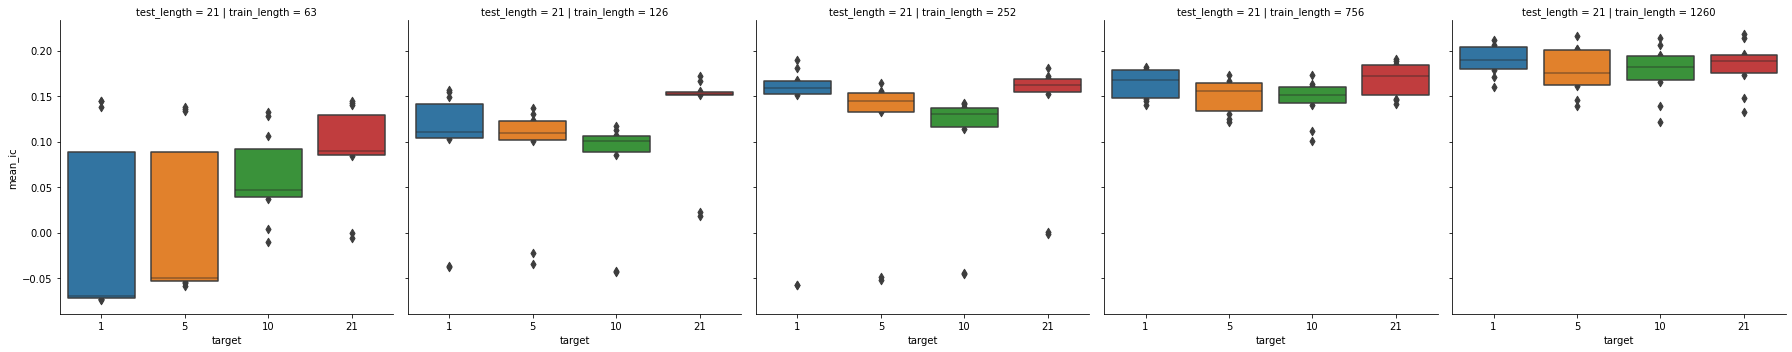

In [32]:
sns.catplot(x='target',
            y='mean_ic',
            col='train_length',
            row='test_length',
            data=cross_val_results[(cross_val_results.test_length == 21)],
            kind='boxen')

As we can see the longer the train periods are the better, the `mean_ic` steadly grows as the train period grows. If
we look also to the test period the previous logic is still true.

Regarding the standard deviation of the `ic` we can see a great decrease when the test length is longer, while the
train period doesn't seem to affect positively the standard deviation.

In [33]:
hyperparam_res = cross_val_results.groupby(by=['n_estimators', 'max_depth', 'min_samples_leaf'])

hyperparam_res.describe()

mean_ic                                \
                                          count      mean       std       min   
n_estimators max_depth min_samples_leaf                                         
100          15        25                  40.0  0.106406  0.079338 -0.129097   
                       100                 40.0  0.038765  0.111369 -0.123358   
250          5         5                   40.0  0.131067  0.035960  0.054038   
                       25                  40.0  0.111725  0.081458 -0.121024   
             15        25                  40.0  0.111182  0.077675 -0.109199   
                       100                 40.0  0.041943  0.116833 -0.125017   

                                                                       \
                                              25%       50%       75%   
n_estimators max_depth min_samples_leaf                                 
100          15        25                0.094483  0.133927  0.157408   
                       100              -0.055186  0.000256  0.145682   
250          5         5                 0.111181  0.131866  0.154056   
                       25                0.089150  0.136055  0.167079   
             15        25                0.090467  0.131186  0.163764   
                       100              -0.056066 -0.003861  0.161026   

                                                  std_ic                      \
                                              max  count      mean       std   
n_estimators max_depth min_samples_leaf                                        
100          15        25                0.191258   40.0  0.252014  0.075007   
                       100               0.218492   40.0  0.225791  0.089147   
250          5         5                 0.202910   40.0  0.255798  0.065391   
                       25                0.204359   40.0  0.249423  0.075139   
             15        25                0.193424   40.0  0.247908  0.076900   
                       100               0.215647   40.0  0.225871  0.088824   

                                                                       \
                                              min       25%       50%   
n_estimators max_depth min_samples_leaf                                 
100          15        25                0.100449  0.190272  0.252833   
                       100               0.091696  0.119819  0.244347   
250          5         5                 0.160335  0.194901  0.253075   
                       25                0.097971  0.185337  0.249538   
             15        25                0.102649  0.183117  0.246283   
                       100               0.099575  0.122617  0.252741   

                                                             
                                              75%       max  
n_estimators max_depth min_samples_leaf                      
100          15        25                0.320884  0.351953  
                       100               0.308245  0.333477  
250          5         5                 0.319331  0.355393  
                       25                0.322756  0.344913  
             15        25                0.321422  0.348232  
                       100               0.301711  0.347245

By giving a first look to the hyperparameters results, we can see that a larger number of estimators
often gives better `ic`, while is not really clear what kind of impact the others two parameters have.

It seems like that a lower number of sample for each leaf often gives a greater `ic`. Let's see if that it is true by
seeing which combination of parameters gives the highest mean ic.

In [34]:
hyperparam_res.apply(lambda x : x.nlargest(3, 'mean_ic')).drop(['n_estimators', 'max_depth', 'min_samples_leaf'], axis=1)

train_length test_length  \
n_estimators max_depth min_samples_leaf                                
100          15        25               210         1260          21   
                                        330          756          21   
                                        10          1260          21   
                       100              313         1260          21   
                                        213         1260          21   
                                        13          1260          21   
250          5         5                18          1260          21   
                                        118         1260          21   
                                        318         1260          21   
                       25               15          1260          21   
                                        115         1260          21   
                                        215         1260          21   
             15        25               11          1260          21   
                                        331          756          21   
                                        311         1260          21   
                       100              114         1260          21   
                                        314         1260          21   
                                        214         1260          21   

                                              mean_ic    std_ic rounds target  
n_estimators max_depth min_samples_leaf                                        
100          15        25               210  0.191258  0.199310     48     10  
                                        330  0.188258  0.172988     48     21  
                                        10   0.178475  0.191318     48      1  
                       100              313  0.218492  0.194269     48     21  
                                        213  0.214202  0.200868     48     10  
                                        13   0.211514  0.186150     48      1  
250          5         5                18   0.202910  0.204972     48      1  
                                        118  0.199101  0.210936     48      5  
                                        318  0.192843  0.195661     48     21  
                       25               15   0.204359  0.187406     48      1  
                                        115  0.201485  0.200486     48      5  
                                        215  0.194974  0.181695     48     10  
             15        25               11   0.193424  0.191673     48      1  
                                        331  0.190337  0.157668     48     21  
                                        311  0.184246  0.185246     48     21  
                       100              114  0.215647  0.197177     48      5  
                                        314  0.213546  0.217785     48     21  
                                        214  0.206146  0.179502     48     10

From the table above we can see that the combinations which gives the best results are `{'n_estimators': 100, 'max_depth':15, 'min_samples_leaf': 100}` and
`{'n_estimators': 250, 'max_depth':15, 'min_samples_leaf': 100}`.

Contrary from what we've supposed before `min_sample_leaf` has to be big in order to achive higher `ic`, maybe because
this parameter can allow building more generalized trees.

`n_estimators` parameter doesn't seem to make a big difference in the model, since the result that
we get from the combinations cited above are almost the same, indeed the model with fewer trees performs better
than the one with more trees.


In [35]:
res_target = cross_val_results.groupby(by='target')

res_target.describe()

mean_ic                                                              \
         count      mean       std       min       25%       50%       75%   
target                                                                       
1        100.0  0.101404  0.097985 -0.104142  0.093441  0.142467  0.166190   
5        100.0  0.081380  0.093985 -0.130113  0.061067  0.112404  0.145439   
10       100.0  0.089174  0.072152 -0.088438  0.052997  0.102117  0.140747   
21       100.0  0.126635  0.055518 -0.029209  0.102021  0.140583  0.166297   

                 std_ic                                                    \
             max  count      mean       std       min       25%       50%   
target                                                                      
1       0.211514  100.0  0.233886  0.071768  0.091696  0.183470  0.239261   
5       0.215647  100.0  0.245758  0.072718  0.113238  0.188912  0.259585   
10      0.214202  100.0  0.256749  0.078257  0.105507  0.192764  0.263666   
21      0.218492  100.0  0.250582  0.078303  0.104441  0.183468  0.256728   

                            
             75%       max  
target                      
1       0.296033  0.337837  
5       0.312624  0.351953  
10      0.331429  0.355429  
21      0.324363  0.346705

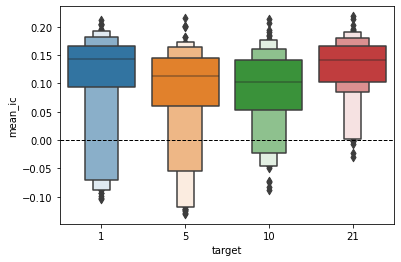

In [36]:
ax = sns.boxenplot(x='target', y='mean_ic', data=cross_val_results)
ax.axhline(0, ls='--', lw=1, c='k')

Now that we've grouped by target (the lookhead of our model) let's see that our previous hypothesis about
the best hyperparameters that we've done before are confirmed.

In [37]:
res_target.apply(lambda x: x.nlargest(3, 'mean_ic')).drop('target', axis=1)

train_length test_length n_estimators max_depth min_samples_leaf  \
target                                                                        
1      13          1260          21          100        15              100   
       14          1260          21          250        15              100   
       15          1260          21          250         5               25   
5      114         1260          21          250        15              100   
       115         1260          21          250         5               25   
       113         1260          21          100        15              100   
10     213         1260          21          100        15              100   
       214         1260          21          250        15              100   
       215         1260          21          250         5               25   
21     313         1260          21          100        15              100   
       314         1260          21          250        15              100   
       304         1260           5          250        15              100   

             mean_ic    std_ic rounds  
target                                 
1      13   0.211514  0.186150     48  
       14   0.205567  0.190428     48  
       15   0.204359  0.187406     48  
5      114  0.215647  0.197177     48  
       115  0.201485  0.200486     48  
       113  0.201258  0.196418     48  
10     213  0.214202  0.200868     48  
       214  0.206146  0.179502     48  
       215  0.194974  0.181695     48  
21     313  0.218492  0.194269     48  
       314  0.213546  0.217785     48  
       304  0.203120  0.327984    201

Guess what? Out hypothesis are confirmed!

The best models have all the best hyperparameters that we've identified before:

`{'n_estimators': 100, 'max_depth':15, 'min_samples_leaf': 100, train_length: 1260, test_length:21}`

In [38]:
base_params = rf_reg.get_params()
model = RandomForestRegressor(base_params)
model_params = {
    'n_estimators': 100,
    'max_depth': 15,
    'max_features': 'log2',
    'min_samples_leaf': 100
}
model = model.set_params(**model_params)
opt_test_length = 21
opt_train_length = 1260

In [39]:
y[f'target_{1}d']

Date
2012-04-09   -0.036070
2012-04-10   -0.023634
2012-04-12   -0.001009
2012-04-13    0.017668
2012-04-16   -0.032242
                ...   
2021-07-26   -0.031936
2021-07-27    0.018383
2021-07-28    0.003709
2021-07-29   -0.035723
2021-07-30    0.005365
Name: target_1d, Length: 2330, dtype: float64

In [40]:
scores = np.array([])

for lookahead in lookaheads:
    n_splits = int(4 * YEAR /  opt_test_length)
    cv = MultipleTimeSeriesCV(
        n_splits=n_splits,
        test_period_length=opt_test_length,
        train_period_length=opt_train_length,
        lookahead=lookahead
    )

    for i, (train_idx, test_idx) in enumerate(cv.split(X)):
        model = model.fit(X.iloc[train_idx], y[f'target_{lookahead}d'].iloc[train_idx])

        y_test = y[f'target_{lookahead}d'].iloc[test_idx]
        y_pred = model.predict(X.iloc[test_idx])
        scores = np.append(scores, rank_correl(y_test, y_pred))
        print(f'Lookhead: {lookahead} | Iteration: {i} | Val score: {scores[-1]}')

Lookhead: 1 | Iteration: 0 | Val score: -0.43766233766233764
Lookhead: 1 | Iteration: 1 | Val score: 0.10519480519480517
Lookhead: 1 | Iteration: 2 | Val score: -0.04025974025974026
Lookhead: 1 | Iteration: 3 | Val score: 0.3649350649350649
Lookhead: 1 | Iteration: 4 | Val score: 0.4194805194805195
Lookhead: 1 | Iteration: 5 | Val score: 0.23636363636363636
Lookhead: 1 | Iteration: 6 | Val score: 0.13116883116883118
Lookhead: 1 | Iteration: 7 | Val score: 0.5402597402597402
Lookhead: 1 | Iteration: 8 | Val score: -0.34545454545454546
Lookhead: 1 | Iteration: 9 | Val score: -0.32857142857142857
Lookhead: 1 | Iteration: 10 | Val score: 0.04155844155844156
Lookhead: 1 | Iteration: 11 | Val score: -0.41558441558441556
Lookhead: 1 | Iteration: 12 | Val score: 0.06623376623376624
Lookhead: 1 | Iteration: 13 | Val score: 0.34415584415584416
Lookhead: 1 | Iteration: 14 | Val score: 0.17922077922077922
Lookhead: 1 | Iteration: 15 | Val score: 0.02857142857142857
Lookhead: 1 | Iteration: 16 | Va

## Evaluate the Best Model

In [41]:
print(rank_correl(model.predict(X.iloc[-30:]), y.target_5d.values[-30:]))

0.7691631459147812


In [42]:
print(rank_correl(model.predict(X.iloc[-30:]), y.target_21d.values[-30:]))


0.481506824542828


## Parameters importance

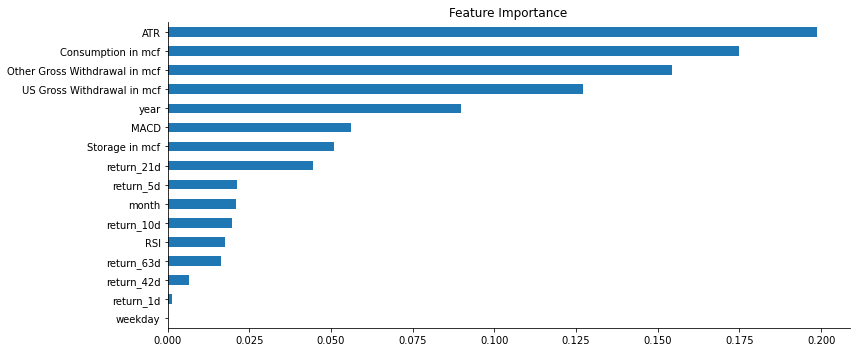

In [43]:

fig, ax = plt.subplots(figsize=(12,5))
(pd.Series(model.feature_importances_, index=X.columns)
 .sort_values(ascending=False)
 .iloc[:20]
 .sort_values()
 .plot.barh(ax=ax, title='Feature Importance'))

sns.despine()

fig.tight_layout();

Using the builtin `features_importances_` attribute from our model we can see that the most impactful params are:

- ATR
- NG consumption
- Other States Gross Withdrawal
- US Gross Withdrawal
- year
- MACD

To have a more holistic view of the importance of the features, we can use two others functions provided by
sklearn: `permutation_importance` and `partial_dependence`.

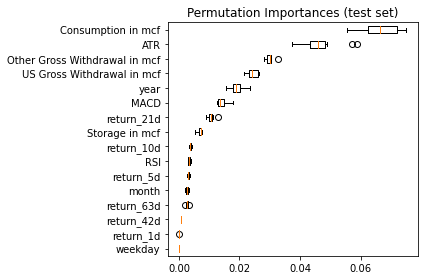

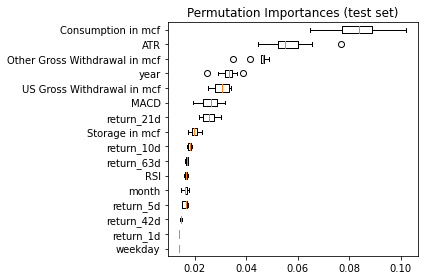

In [45]:
from sklearn.inspection import permutation_importance, PartialDependenceDisplay, partial_dependence

result = permutation_importance(model, X, y.target_21d, n_repeats=10, n_jobs=-1, max_samples=0.3)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [ ]:
result = permutation_importance(model, X, y.target_21d, n_repeats=10, n_jobs=-1, max_samples=0.3)

sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [50]:
X

,Consumption in mcf,Storage in mcf,US Gross Withdrawal in mcf,Other Gross Withdrawal in mcf,RSI,ATR,MACD,return_1d,return_5d,return_10d,return_21d,return_42d,return_63d,year,month,weekday
Date,,,,,,,,,,,,,,,,
2012-04-09,1953071.0,2478.0,2417498.0,93400.0,34.901425,0.089792,-0.081938,0.008617,-0.001794,-0.007642,-0.003584,-0.003797,-0.005916,2012,4,0
2012-04-10,1953071.0,2478.0,2417498.0,93400.0,30.556017,0.090521,-0.086858,-0.036070,-0.011507,-0.009126,-0.006397,-0.004436,-0.006230,2012,4,1
2012-04-12,1953071.0,2478.0,2417498.0,93400.0,28.170441,0.090913,-0.093349,-0.023634,-0.019393,-0.010690,-0.006395,-0.005282,-0.006237,2012,4,3
2012-04-13,1953071.0,2503.0,2417498.0,93400.0,28.072097,0.087276,-0.097552,-0.001009,-0.015414,-0.010025,-0.007064,-0.005306,-0.005330,2012,4,4
2012-04-16,1953071.0,2503.0,2417498.0,93400.0,32.512260,0.084828,-0.097134,0.017668,-0.007089,-0.006368,-0.005926,-0.004447,-0.004609,2012,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-26,2218011.0,2714.0,3396062.0,32500.0,79.676063,0.129331,0.175313,0.010345,0.016538,0.009039,0.008724,0.008183,0.006137,2021,7,0
2021-07-27,2218011.0,2714.0,3396062.0,32500.0,67.674236,0.132950,0.170944,-0.031936,0.004855,0.007202,0.006085,0.006827,0.005151,2021,7,1
2021-07-28,2218011.0,2714.0,3396062.0,32500.0,70.354143,0.137025,0.171060,0.018383,0.004258,0.010027,0.005647,0.007474,0.005155,2021,7,2


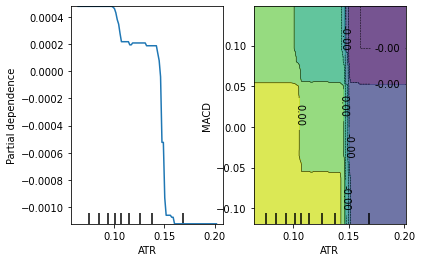

In [51]:
PartialDependenceDisplay.from_estimator(model, X, [5, (5, 6)])